In [17]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import pyproj
import shapely.geometry
from shapely.geometry import Point
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import numpy as np
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube
import xesmf as xe
import cartopy.crs as ccrs
import contextily as ctx
from scipy import stats

# imports for rasterizing 
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import xwrf

# dask
import dask
from dask.distributed import Client, LocalCluster

                      geometry
0  POINT (-117.37994 33.21477)
1  POINT (-117.35818 33.21405)
2  POINT (-117.34729 33.21370)
3  POINT (-117.33643 33.21334)
4  POINT (-117.32553 33.21298)


Text(35.225572519363496, 0.5, 'Latitude')

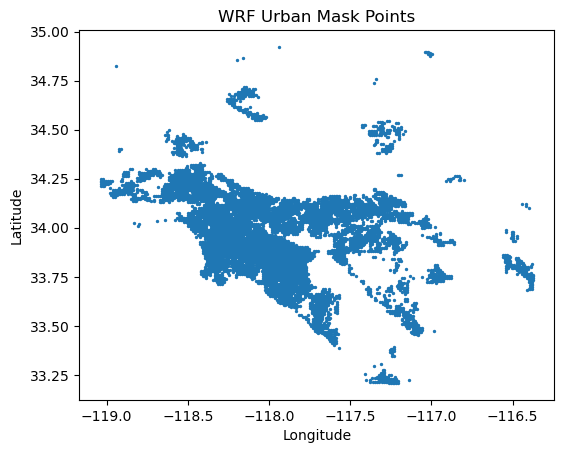

In [18]:
# Load the GeoPackage file
gdf = gpd.read_file("/home1/kojoseph/ah-la-paper/data/wrf_urban_mask.gpkg")

# Print the first few rows to check
print(gdf.head())

# Plot the points
gdf.plot(markersize=2)
plt.title("WRF Urban Mask Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.show()

In [19]:
# pre-define labels for easy re-use
# \mathrm{} prevents exprsesion from getting italicized 
# \/ within the latex expression is necessary for an empty space
degree_sign = u'\N{DEGREE SIGN}'
del_ta_label = r'$\mathrm{{\Delta}T_{2m}}$ (' + degree_sign + 'C)'
del_tc_label = r'$\mathrm{{\Delta}T_{c}}$ (' + degree_sign + 'C)'
ahf_label = r'Anthropogenic heat flux ($\mathrm{W\/m^{-2}}$)'
ws_label = r'$\mathrm{{\Delta}}$WS ($\mathrm{m\/s^{-1}}$)'
pblh_label = r'$\mathrm{{\Delta}}$PBLH (m)'

# color shortcutes
max_red = '#DD1717'  # red
yale_blue = '#0F4392'  # blue

# where to save plots
plot_dir ='/home1/kojoseph/ah-la-paper/figs/draft_v1'
os.makedirs(plot_dir, exist_ok=True)

# Default - Control

Assuming deltas have been pre-computed and saved using `deltas-analysis.py` script.

In [20]:
# import deltas data
deltas = {}
data_dir = '/home1/kojoseph/ah-la-paper/data/deltas-urban-wrf'
nc_files = glob.glob(f"{data_dir}/*.nc")
for f in nc_files:
    filename = os.path.basename(f)
    delta_id = filename.split('.')[0]
    ds = xr.open_dataset(f)
    deltas[delta_id] = ds

## T2 (2 meter air temperature)

Summer: Max mean at hour 7 with value 0.375
Summer: Min mean at hour 15 with value 0.098
Winter: Max mean at hour 17 with value 0.362
Winter: Min mean at hour 4 with value 0.207


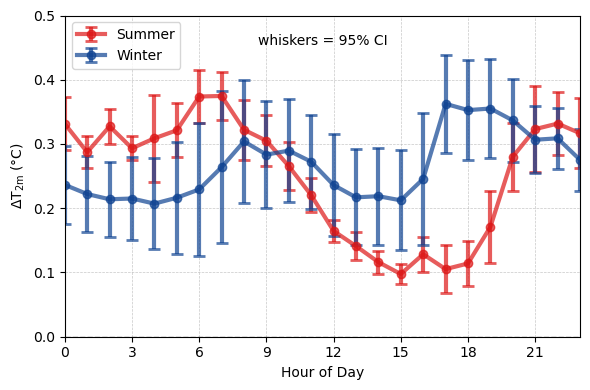

In [21]:
# Diurnal plot for delta(T2)
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(0, 0.5)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-t2-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

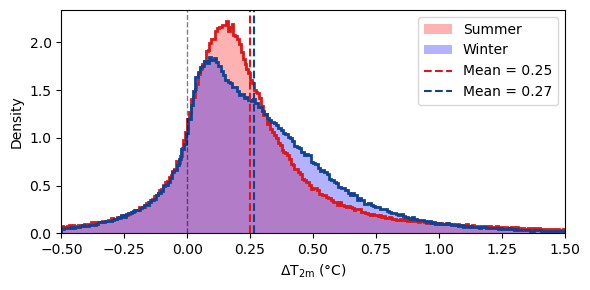

In [22]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-0.5, 1.5)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_ta_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-t2-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [23]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for T2 for month 8 ===
t-statistic: 3.72e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 1.48e+10, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for T2 for month 12 ===
t-statistic: 5.19e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 1.16e+10, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)


## TC_URB (canopy air temperature)

Summer: Max mean at hour 8 with value 1.422
Summer: Min mean at hour 4 with value 0.774
Winter: Max mean at hour 8 with value 1.688
Winter: Min mean at hour 4 with value 1.175


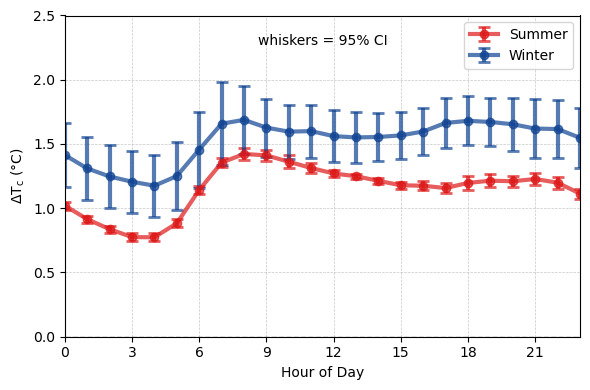

In [24]:
# Diurnal plot for delta(T2)
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(0, 2.5)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-tc-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")         

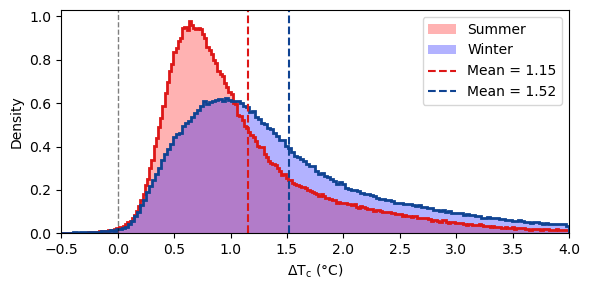

In [25]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-0.5, 4.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_tc_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-tc-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [26]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for TC_URB for month 8 ===
t-statistic: 9.00e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 3.91e+07, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for TC_URB for month 12 ===
t-statistic: 9.54e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 1.11e+08, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)


## WS (Wind Speed)

Summer: Max mean at hour 6 with value 0.073
Summer: Min mean at hour 18 with value -0.003
Winter: Max mean at hour 19 with value 0.126
Winter: Min mean at hour 9 with value -0.023


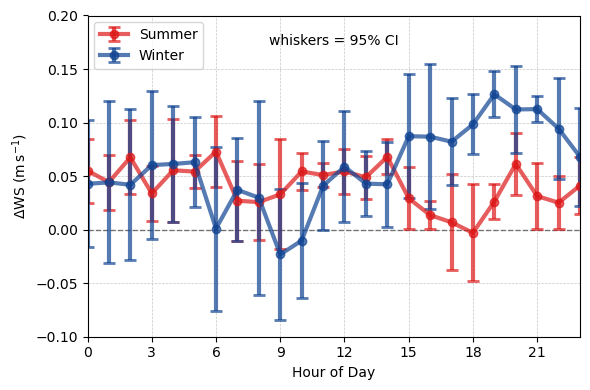

In [27]:
# Diurnal plot for delta(T2)
v = 'WS'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(ws_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-0.1, 0.2)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-ws-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)            

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

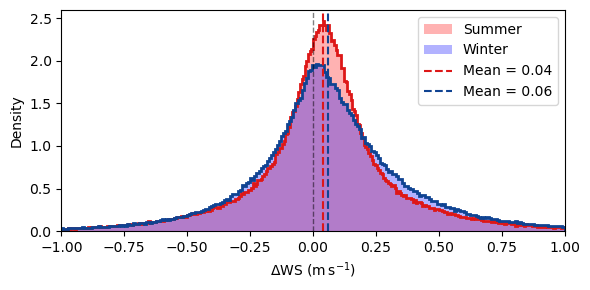

In [28]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-1.0, 1.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(ws_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-ws-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [29]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for WS for month 8 ===
t-statistic: 8.51e+01, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 4.59e+10, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for WS for month 12 ===
t-statistic: 1.06e+02, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 4.54e+10, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)


## PBL

Summer: Max mean at hour 10 with value 24.907
Summer: Min mean at hour 19 with value 9.510
Winter: Max mean at hour 17 with value 75.807
Winter: Min mean at hour 5 with value 5.233


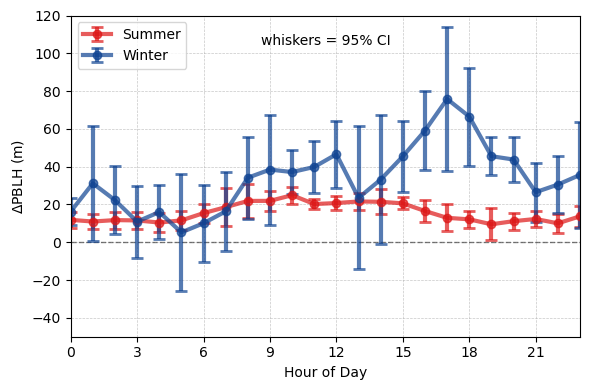

In [30]:
# Diurnal plot for delta(T2)
v = 'PBLH'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)

ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(pblh_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-50, 120)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-pbl-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

Note: for histograms and statistical tests, coarsen PBL to 10km first. 

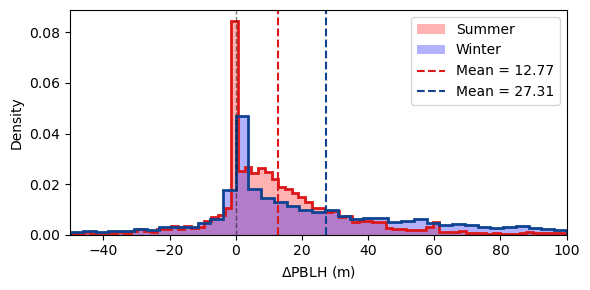

In [31]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-50, 100)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    ds = deltas[delta_id][v]
    ds = ds.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_dict[m] = ds
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]

# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(pblh_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# ax.set_yscale('log')  # <-- Add this line for log scale on y-axis
# save plot
save_filename = 'hist-pbl-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [32]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta = delta.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

=== Statistical test for PBLH for month 8 ===
t-statistic: 2.31e+01, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 8.21e+06, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
=== Statistical test for PBLH for month 12 ===
t-statistic: 2.62e+01, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
Wilcoxon statistic: 9.56e+06, p-value: < 1e-16
>>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)
